# Getting info on Priming experiment dataset that's needed for modeling

## Info:


* Infer total richness of starting community
* Get distribution of total OTU abundances per fraction
  * Number of sequences per sample
* Infer total abundance of each target taxon

# User variables

In [4]:
baseDir = '/home/nick/notebook/SIPSim/dev/priming_exp/'
workDir = os.path.join(baseDir, 'exp_info')

otuTableFile = '/var/seq_data/priming_exp/data/otu_table.txt'
otuTableSumFile = '/var/seq_data/priming_exp/data/otu_table_summary.txt'

#otuRepFile = '/var/seq_data/priming_exp/otusn.pick.fasta'
#otuTaxFile = '/var/seq_data/priming_exp/otusn_tax/otusn_tax_assignments.txt'
#genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'

# Init

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(fitdistrplus)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [36]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Total richness of starting community

Method:

* Total number of OTUs in OTU table (i.e., gamma richness)
* Just looking at bulk soil samples

In [7]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t') %>%
    select(matches('X00C'), OTUId)

print('Number of samples: ')
print(ncol(tbl))

print('Number of OTUs: ')
print(nrow(tbl))

[1] "Number of samples: "
[1] 14
[1] "Number of OTUs: "
[1] 10361


In [9]:
%%R

tbl.h = tbl %>% 
    gather('sample', 'count', 1:13)
tbl.h %>% head    

      OTUId            sample count
1  OTU.4776 X00C.000.14.09.NA    60
2  OTU.2864 X00C.000.14.09.NA     1
3  OTU.8170 X00C.000.14.09.NA     0
4  OTU.8762 X00C.000.14.09.NA     0
5  OTU.5223 X00C.000.14.09.NA     1
6 OTU.13091 X00C.000.14.09.NA     0


In [11]:
%%R

tbl.hs = tbl.h %>%
    group_by(OTUId) %>%
    summarize(
        total_count = sum(count),
        mean_count = mean(count),
        median_count = median(count),
        sd_count = sd(count)
    ) %>%
    filter(total_count > 0)

message('Number of samples: ', tbl.hs %>% ncol)
message('Number of OTUs: ', tbl.hs %>% distinct(OTUId) %>% nrow)
message('------')
tbl.hs %>% head

Number of samples: 5
Number of OTUs: 5695
------
Source: local data frame [6 x 5]

      OTUId total_count   mean_count median_count    sd_count
1     OTU.1        2084 160.30769231           87 166.9971979
2    OTU.10          11   0.84615385            0   1.3445045
3   OTU.100         608  46.76923077           28  52.8001797
4  OTU.1000          13   1.00000000            1   1.2909944
5 OTU.10000           1   0.07692308            0   0.2773501
6  OTU.1001          12   0.92307692            0   1.9348358


In [13]:
%%R

message('Bulk soil total richness: ', tbl.hs %>% distinct(OTUId) %>% nrow)

Bulk soil total richness: 5695


# Distribution of total OTU abundances per fraction
  
* Number of sequences per sample

Method:

* Total number of sequences (total abundance) per sample

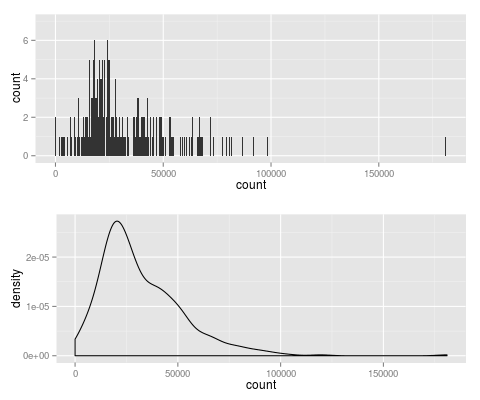

In [36]:
%%R -h 400

tbl.s = apply(tbl, 2, sum) %>% as.data.frame
colnames(tbl.s) = c('count')

p = ggplot(tbl.s, aes(count)) 
p1 = p + geom_histogram(binwidth=200) 
p2 = p + geom_density()

grid.arrange(p1,p2,ncol=1)

### Distribution fitting

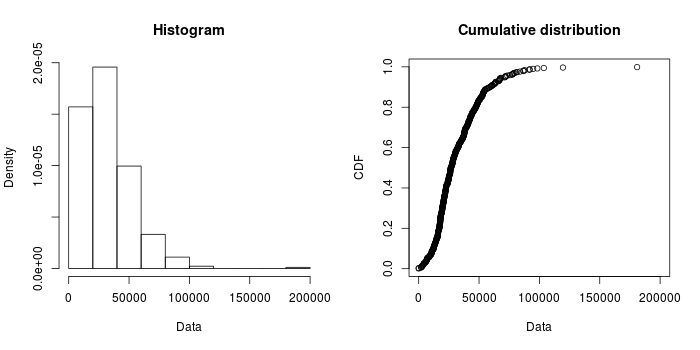

In [40]:
%%R -w 700 -h 350
plotdist(tbl.s$count)

summary statistics
------
min:  2   max:  180942 
median:  26730.5 
mean:  32344.51 
estimated sd:  20700.43 
estimated skewness:  1.731291 
estimated kurtosis:  9.42882 


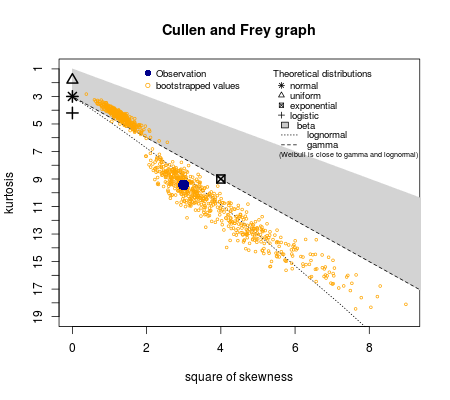

In [45]:
%%R -w 450 -h 400
descdist(tbl.s$count, boot=1000)

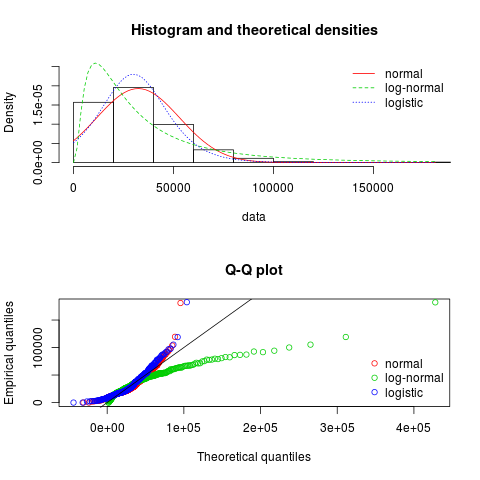

In [68]:
%%R
f.n = fitdist(tbl.s$count, 'norm')
f.ln = fitdist(tbl.s$count, 'lnorm')
f.ll = fitdist(tbl.s$count, 'logis')
#f.c = fitdist(tbl.s$count, 'cauchy')
f.list = list(f.n, f.ln, f.ll)

plot.legend = c('normal', 'log-normal', 'logistic')

par(mfrow = c(2,1))
denscomp(f.list, legendtext=plot.legend)
qqcomp(f.list, legendtext=plot.legend)

In [69]:
%%R

gofstat(list(f.n, f.ln, f.ll), fitnames=plot.legend)

Goodness-of-fit statistics
                                 normal log-normal   logistic
Kolmogorov-Smirnov statistic  0.1174809  0.1425522 0.07888578
Cramer-von Mises statistic    1.8311610  2.3025425 0.90026633
Anderson-Darling statistic   10.5910283 15.0386590 6.99794180

Goodness-of-fit criteria
                                 normal log-normal logistic
Aikake's Information Criterion 10269.59   10385.40 10220.63
Bayesian Information Criterion 10277.82   10393.63 10228.86


In [62]:
%%R
summary(f.ln)

Fitting of the distribution ' lnorm ' by maximum likelihood 
Parameters : 
          estimate Std. Error
meanlog 10.1466551 0.04334405
sdlog    0.9215072 0.03064871
Loglikelihood:  -5190.7   AIC:  10385.4   BIC:  10393.63 
Correlation matrix:
        meanlog sdlog
meanlog       1     0
sdlog         0     1



#### Notes:

* best fit:
  * lognormal
    * mean = 10.147
    * sd = 0.922

# Total abundance of each target taxon (relative abundance in pre-gradient community)


* Getting relative abundances from bulk soil samples


In [4]:
%%R -i otuTableFile

tbl = read.delim(otuTableFile, sep='\t')

print('Number of samples: ')
print(ncol(tbl))

print('Number of OTUs: ')
print(nrow(tbl))

[1] "Number of samples: "
[1] 468
[1] "Number of OTUs: "
[1] 10361


In [10]:
%%R
tbl %>% head

      OTUId X12C.700.45.01.24 X12C.700.14.06.14 X12C.100.14.05.18
1  OTU.4776               157                34                13
2  OTU.2864                 0                 1                 2
3  OTU.8170                 0                 0                 0
4  OTU.8762                 0                 0                 0
5  OTU.5223                 0                 0                 0
6 OTU.13091                 0                 0                 0
  X12C.700.14.06.05 X12C.000.14.05.18 X12C.100.14.05.11 X12C.100.28.03.18
1               142               136                44               315
2                16                 1                 2                 1
3                 0                 0                 0                 0
4                 0                 1                 0                 0
5                 0                 0                 0                 1
6                 0                 0                 0                 0
  X13C.000.28.06.10 

In [21]:
%%R
# filtering

tbl.bulk = tbl %>% 
    select(matches('X00C'), OTUId)

print('Number of samples: ')
print(ncol(tbl.bulk))

print('Number of OTUs: ')
print(nrow(tbl.bulk))

[1] "Number of samples: "
[1] 14
[1] "Number of OTUs: "
[1] 10361


In [24]:
%%R

tbl.h = tbl.bulk %>% 
    gather('sample', 'count', 1:13)
tbl.h %>% head    

      OTUId            sample count
1  OTU.4776 X00C.000.14.09.NA    60
2  OTU.2864 X00C.000.14.09.NA     1
3  OTU.8170 X00C.000.14.09.NA     0
4  OTU.8762 X00C.000.14.09.NA     0
5  OTU.5223 X00C.000.14.09.NA     1
6 OTU.13091 X00C.000.14.09.NA     0


In [32]:
%%R

tbl.hs = tbl.h %>%
    group_by(OTUId) %>%
    summarize(
        total_count = sum(count),
        mean_count = mean(count),
        median_count = median(count),
        sd_count = sd(count)
    ) %>%
    filter(total_count > 0)

message('Number of samples: ', tbl.hs %>% ncol)
message('Number of OTUs: ', tbl.hs %>% distinct(OTUId) %>% nrow)

tbl.hs %>% head

Number of samples: 5
Number of OTUs: 5695
Source: local data frame [6 x 5]

      OTUId total_count   mean_count median_count    sd_count
1     OTU.1        2084 160.30769231           87 166.9971979
2    OTU.10          11   0.84615385            0   1.3445045
3   OTU.100         608  46.76923077           28  52.8001797
4  OTU.1000          13   1.00000000            1   1.2909944
5 OTU.10000           1   0.07692308            0   0.2773501
6  OTU.1001          12   0.92307692            0   1.9348358


In [37]:
%%R -i workDir
setwd(workDir)

outFile = 'bulk_OTU_abund_stats.txt'

write.table(tbl.hs, outFile, sep='\t', quote=F, row.names=F)